### 4.1 AlexNet

- `ImageNet 数据集` (3 x 224 x 224)
- 1个11x11的大卷积层，然后跟着5x5中型卷积层，再紧接着连续三个3x3的卷积层
- 激活函数从 Sigmoid 换成了 ReLU

![AlexNet网络结构图](https://zh.d2l.ai/_images/alexnet.svg)


In [1]:
import torch
import torch.nn as nn

In [30]:
class AlexNet(nn.Module):
    """ AlexNet 深层卷积神经网络 """
    def __init__(self):
        super().__init__()
        # 卷积层
        self.conv = nn.Sequential(nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
                                  nn.ReLU(), 
                                  nn.MaxPool2d(kernel_size=3, stride=2), 
                                  
                                  nn.Conv2d(96, 256, kernel_size=5, padding=2), 
                                  nn.ReLU(), 
                                  nn.MaxPool2d(kernel_size=3, stride=2), 
                                  
                                  # 使用3个连续的 3x3 卷积层
                                  nn.Conv2d(256, 384, kernel_size=3, padding=1), 
                                  nn.ReLU(), 
                                  nn.Conv2d(384, 384, kernel_size=3, padding=1), 
                                  nn.ReLU(), 
                                  nn.Conv2d(384, 256, kernel_size=3, padding=1), 
                                  nn.ReLU(), 
                                  nn.MaxPool2d(kernel_size=3, stride=2), 
                                  
                                  nn.Flatten())
        
        self.fc = nn.Sequential(nn.Linear(5*5*256, 4096), 
                                nn.ReLU(), 
                                nn.Linear(4096, 4096), 
                                nn.ReLU(), 
                                nn.Linear(4096, 10))
        
    def forward(self, x):
        """ 前向传播方法 """
        x_flatten = self.conv(x)
        return self.fc(x_flatten)

In [32]:
model = AlexNet()

In [34]:
x = torch.rand(16, 1, 224, 224)
output = model(x)
output.shape

torch.Size([16, 10])

In [36]:
y_true = 0

In [38]:
y_true += (torch.tensor([9, 0, 1,2,3,4,5,6,7,8,9,0, 1,2,3,4]) == torch.argmax(output, dim=-1)).sum().item()
y_true

1

#### 4.1.1 DataLoader

In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Resize((224, 224))])

mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download = True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download = True)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
train_dataloader = DataLoader(mnist_train, batch_size=256, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=256, shuffle=False)

len(train_dataloader), len(test_dataloader)

(235, 40)

#### 4.1.2 Model

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [48]:
model = AlexNet().to(device)
model

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_featu

#### 4.1.3 Train & Test Model

In [189]:
x, y = next(iter(train_dataloader))
x.shape, y.shape

(torch.Size([256, 1, 224, 224]), torch.Size([256]))

In [191]:
def train_model(model,train_dataloader,loss_func,optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0.
    for x,y in train_dataloader:
        y_hat = model(x.to(device))
        loss = loss_func(y_hat,y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_dataloader)

def test_model(model,train_dataloader,loss_func):
    """ 模型测试函数 """
    model.eval()

    y_true = 0
    total_loss = 0.
    for x,y in train_dataloader:
        y_hat = model(x.to(device))
        loss = loss_func(y_hat,y.to(device))

        y_true += (y == torch.argmax(y_hat, dim=-1)).sum().item()

        total_loss += loss.item()
    print(f'Acc:{round(y_true / len(test_dataloader.dataset))}')
    return total_loss / len(test_dataloader)

In [82]:
model = AlexNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [84]:
n_epoch = 5

train_loss_list = []
test_loss_list = []
for i in range(n_epoch):
    train_loss = train_model(model, train_dataloader, loss_func, optimizer)
    test_loss, acc = test_model(model, train_dataloader, loss_func)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print(train_loss)

0.7140229557422881
0.34150512516498566
0.29000242606122445
0.25015607863030537
0.2255410944527768


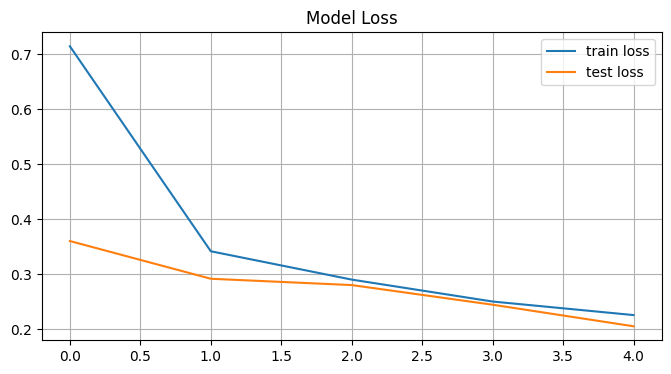

In [86]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()